In [1]:
import darshan
darshan.enable_experimental(verbose=False)

import pprint

from darshan.experimental.plots import plot_access_histogram
from darshan.experimental.plots import plot_opcounts

### Report Algebra

Reports come with a number of operations which can be applied to them. For a number of common combinations a shorthand notations can be used, which exploits operator overloading. This can be useful in a variety of contexts such as analysis, as well as performance projection and extrapolation.

    Operation                        Returns Interpreation
    ---------                        ------- -------------
    report + report              =>  report: merge reports - equivalant to .merge()
    report + datetime.timedelta  =>  report: all report records are moved in time

    report * scalar              =>  report: all report records are dublicated 'scalar' times
                                             integer multiplication is well defined
                                             float multiplication is only defined after reduction

More operations are discussed at the end of the notebook.

#### Example:

In [2]:
import darshan
import copy

darshan.enable_experimental(verbose=False)

In [42]:
%%time
r1 = darshan.DarshanReport("example-logs/sample.darshan", read_all=True)
r2 = darshan.DarshanReport("example-logs/noposix.darshan", read_all=True)
r3 = darshan.DarshanReport("example-logs/sample-badost.darshan", read_all=True)

CPU times: user 336 ms, sys: 15.9 ms, total: 352 ms
Wall time: 342 ms


In [6]:
# display some info about each report for comparison
for i, r in enumerate([r1, r2, r3]):
    print(f"r{i+1}")
    r.info(metadata=False)
    print()

r1
Filename:       example-logs/sample.darshan
Times:          2017-03-20 10:07:47 to 2017-03-20 10:09:43 (Duration 0:01:56)
Executeable:    /global/project/projectdirs/m888/glock/tokio-abc-results/bin.edison/vpicio_uni /scratch2/scratchdirs/glock/tokioabc-s.4478544/vpicio/vpicio.hdf5 32
Processes:      2048
JobID:          4478544
UID:            69615
Modules in Log: ['POSIX', 'MPI-IO', 'LUSTRE', 'STDIO']
Loaded Records: {'POSIX': 1, 'MPI-IO': 1, 'STDIO': 129, 'LUSTRE': 1}
Name Records:   4
Darshan/Hints:  {'lib_ver': '3.1.3', 'h': 'romio_no_indep_rw=true;cb_nodes=4'}
DarshanReport:  id(139717372215152) (tmp)

r2
Filename:       example-logs/noposix.darshan
Times:          2018-01-02 20:57:35 to 2018-01-03 07:51:07 (Duration 10:53:32)
Executeable:    160345792
Processes:      512
JobID:          83017637
UID:            996599276
Modules in Log: ['LUSTRE', 'STDIO']
Loaded Records: {'STDIO': 2, 'LUSTRE': 519}
Name Records:   522
Darshan/Hints:  {'lib_ver': '3.1.4', 'h': 'romio_no_inde

### Merging Multiple Reports

In [9]:
# merge two reports
c = r1 + r2          # alternatives:  r1.merge(r2)  or  darshan.merge(r1, r2)   ?
c.info()

Filename:       None
Times:          2017-03-20 10:07:47 to 2018-01-03 07:51:07 (Duration 288 days, 21:43:20)
Loaded Records: {'POSIX': 1, 'MPI-IO': 1, 'STDIO': 131, 'LUSTRE': 520}
Name Records:   523
DarshanReport:  id(139717372211648) (tmp)


In [10]:
c.records

{'POSIX': <darshan.report.DarshanRecordCollection at 0x7f127c56f0d0>,
 'MPI-IO': <darshan.report.DarshanRecordCollection at 0x7f127c56f070>,
 'STDIO': <darshan.report.DarshanRecordCollection at 0x7f127c56f250>,
 'LUSTRE': <darshan.report.DarshanRecordCollection at 0x7f127c56fa00>}

In [11]:
c.info()

Filename:       None
Times:          2017-03-20 10:07:47 to 2018-01-03 07:51:07 (Duration 288 days, 21:43:20)
Loaded Records: {'POSIX': 1, 'MPI-IO': 1, 'STDIO': 131, 'LUSTRE': 520}
Name Records:   523
DarshanReport:  id(139717372211648) (tmp)


Summarizing... iohist MPI-IO


<module 'matplotlib.pyplot' from '/home/pq/p/software/darshan-pydarshan/darshan-util/pydarshan/devenv/venv/lib64/python3.9/site-packages/matplotlib/pyplot.py'>

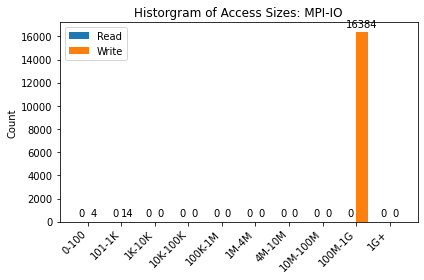

In [12]:
# combined plot:
plot_access_histogram(c, 'MPI-IO')

Summarizing... agg_ioops
Read,Write,Open,Stat,Seek,Mmap,Fsync,Layer
0,16402,2049,0,16404,0,0,POSIX
0,18,0,0,0,0,0,MPIIND
0,16384,2048,0,0,0,0,MPICOL
199687,2190511,1153,0,203265,0,217126,STDIO



<module 'matplotlib.pyplot' from '/home/pq/p/software/darshan-pydarshan/darshan-util/pydarshan/devenv/venv/lib64/python3.9/site-packages/matplotlib/pyplot.py'>

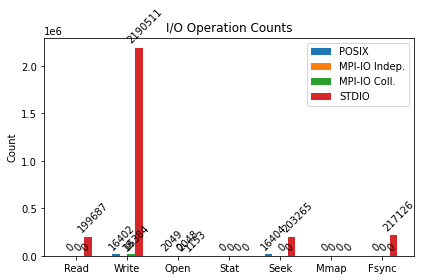

In [13]:
# combined plot:
plot_opcounts(c)

[('POSIX', 13), ('MPI-IO', 13), ('STDIO', 1677), ('LUSTRE', 13)]
Summarizing... agg_ioops
Read,Write,Open,Stat,Seek,Mmap,Fsync,Layer
0,213226,26637,0,213252,0,0,POSIX
0,234,0,0,0,0,0,MPIIND
0,212992,26624,0,0,0,0,MPICOL
0,962,1677,0,0,0,0,STDIO



<module 'matplotlib.pyplot' from '/home/pq/p/software/darshan-pydarshan/darshan-util/pydarshan/devenv/venv/lib64/python3.9/site-packages/matplotlib/pyplot.py'>

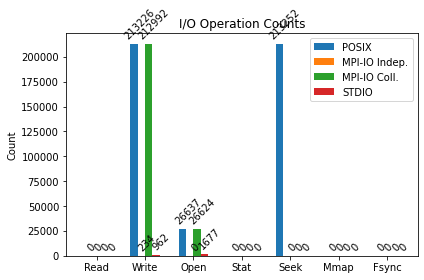

In [41]:
c1 = r1
c2 = r3 + r3 + r3
c = c1 + c2 + c2 + c2 + c2

print([(key, len(val)) for key, val in c.records.items()])
#plot_access_histogram(c, 'POSIX')
plot_opcounts(c)

In [15]:
combined = r1 + r2
[(key, len(val)) for key, val in combined.records.items()]

[('POSIX', 1), ('MPI-IO', 1), ('STDIO', 131), ('LUSTRE', 520)]

## Aggregations and Summaries

A report object allows to attach summaries, which can be useful when planning to export data including different summerizations. It also allows to cache compute intensive summaries in interactive sessions.

Summarizing... iohist POSIX


<module 'matplotlib.pyplot' from '/home/pq/p/software/darshan-pydarshan/darshan-util/pydarshan/devenv/venv/lib64/python3.9/site-packages/matplotlib/pyplot.py'>

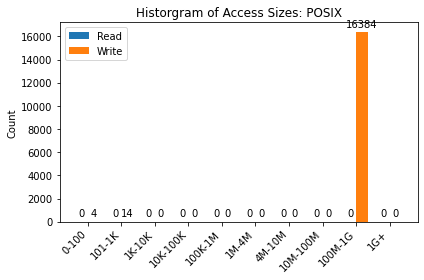

In [19]:
import darshan
darshan.enable_experimental()

r3 = darshan.DarshanReport("example-logs/example.darshan", dtype='numpy')
r3.mod_read_all_records('POSIX')
r3.mod_read_all_records('MPI-IO')


from darshan.experimental.plots import plot_access_histogram
plot_access_histogram(r3, mod='POSIX')

In [20]:
r3.mod_agg_iohist('POSIX')

{'READ_0_100': 0,
 'READ_100_1K': 0,
 'READ_1K_10K': 0,
 'READ_10K_100K': 0,
 'READ_100K_1M': 0,
 'READ_1M_4M': 0,
 'READ_4M_10M': 0,
 'READ_10M_100M': 0,
 'READ_100M_1G': 0,
 'READ_1G_PLUS': 0,
 'WRITE_0_100': 4,
 'WRITE_100_1K': 14,
 'WRITE_1K_10K': 0,
 'WRITE_10K_100K': 0,
 'WRITE_100K_1M': 0,
 'WRITE_1M_4M': 0,
 'WRITE_4M_10M': 0,
 'WRITE_10M_100M': 0,
 'WRITE_100M_1G': 16384,
 'WRITE_1G_PLUS': 0}

## Provenance

The report object maintains a provenance log to investigate and trace aggregations (recording can be disabled by changing `record_provenance` to `False`). Two indexes are maintained:

* A list of all included sub-reports which hold records in the current report
* A list of all alterings/filterings performed on the current report with timestamps/revision

In [21]:
c.provenance_graph

[('add',
  datetime.datetime(2021, 3, 15, 18, 8, 37, 475553))]

## Notes on Additional Operations

This section collections other possible intepretations to common operations / input pairs.

    Operation                        Returns Interpreation
    ---------                        ------- -------------
    report + report              =>  report: merge reports - equivalant to .merge()
    (report + record)            =>  report: existing report with the record added? (but might as well require also individual records to be wrapped in a report)
    report + datetime.timedelta  =>  report: all report records are moved in time

    report * scalar              =>  report: all report records are dublicated 'scalar' times
                                             integer multiplication is well defined
                                             float multiplication is only defined after reduction    
                                             Maybe better implemeted through a method to allow masking (e.g., apply only to records matching criteria... apply only to (subset of?) float/int records)
                                             
    report - report              =>  report: remove matching records from left report

    # Considered, but likely only implemented as a special function
    report / report              =>  dict?:  various factors of whether the right reports can be part of left
                                             for example, how often into duration, how often per layer
                                             right report likely, has to use patterns to be useful
    report * datetime.timedelta  =>  report: skew I/O activity timeline (start/end, dxt traces)
    
    # Undefined (most typical operators just don't offer a meaningful interpretation)
    report * report
    
    arithmetic:
    + addition
    - substraction
    * multiplication
    / devision
    % modulus
    ** exponent
    // floor devision
    
    comparison:
    == equals
    != not equal
    >
    <
    >=
    <=
    
    bitwise:
    & and
    | or
    ^ xor
    ~ flip bits (operator is unary)
    << left shift
    >> right shift
    
    logical:
    and
    or
    not
    
    membership:
    in
    not in
    
    identity:
    is
    is not
    
    